In [3]:
%load_ext autoreload
import sys
sys.path.append("..")


In [4]:
%matplotlib inline

In [5]:
%autoreload

import matplotlib
matplotlib.rc_file('matplotlibrc')
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d
from scipy.interpolate import interp2d
import numpy as np

import darkhistory.physics as phys
from darkhistory.history.tla import get_history

import main
import config
from tqdm import tqdm_notebook as tqdm


from astropy.io import fits



In [147]:
phys.rho_DM/phys.rho_baryon

5.364327223960661

In [220]:
log10eng0 = 3.6989700794219966
log10eng_arr = np.array([log10eng0 + 0.23252559*i for i in np.arange(40)])

log10eng_arr = np.log10(10**log10eng_arr + phys.me)
log10eng_arr[-1] = 12.60

f_idl_low = np.zeros((log10eng_arr.size, 5, 6398))
f_idl_high = np.zeros_like(f_idl_low)


In [221]:
log10eng_arr[8:16]

array([5.94120711, 6.05308337, 6.19544756, 6.3649522 , 6.55583842,
       6.76199572, 6.97830735, 7.20105209])

In [222]:
np.log10(10**log10eng_arr - phys.me)[8:16]

array([5.5591748 , 5.79170039, 6.02422598, 6.25675157, 6.48927716,
       6.72180275, 6.95432834, 7.18685393])

In [223]:
result_decay = [
    main.evolve(
        primary='elec_delta',
        DM_process='decay', mDM=eng*2, lifetime=3e26,
        start_rs = 3000, end_rs=5.1,
        coarsen_factor=12, backreaction=False
    ) for eng in 10**log10eng_arr[8:16]
]

# (eng_phot, result_decay) = pickle.load(open('/Users/hongwan/Desktop/decay_phot_results.p','rb'))

In [215]:
float_formatter = lambda x,n: ("{:."+str(n)+"E}").format(x,n)
    
for log10eng,f_low,f_high  in zip(tqdm(log10eng_arr), f_idl_low, f_idl_high):
    
    eng_string = float_formatter(log10eng,3)
    file = '/Users/hongwan/Dropbox (MIT)/Photon Deposition/idl_comparison/GR_Checks/ih_continuous_phot/calcfracs_tf_z_3.000E+03_nstep_6398_logE_'+eng_string+'_xe_0.000E+00.fits'
    hdul = fits.open(file)
    data = hdul[1].data
    f_low *= 0
    f_high *= 0
    f_low += data.field('loweng_deposition_fractions')[0]
    f_high += data.field('higheng_deposition_fractions')[0]
    idl_redshift   = data.field('redshift')[0]
    hdul.close()

In [228]:
f_low_H_ion_arr = np.array([res['f']['low']['H ion'] for res in result_decay])
f_low_He_ion_arr = np.array([res['f']['low']['He ion'] for res in result_decay])
f_low_exc_arr = np.array([res['f']['low']['exc'] for res in result_decay])
f_low_heat_arr = np.array([res['f']['low']['heat'] for res in result_decay])
f_low_cont_arr = np.array([res['f']['low']['cont'] for res in result_decay])

f_high_H_ion_arr = np.array([res['f']['high']['H ion'] for res in result_decay])
f_high_He_ion_arr = np.array([res['f']['high']['He ion'] for res in result_decay])
f_high_exc_arr = np.array([res['f']['high']['exc'] for res in result_decay])
f_high_heat_arr = np.array([res['f']['high']['heat'] for res in result_decay])
f_high_cont_arr = np.array([res['f']['high']['cont'] for res in result_decay])


In [155]:
fz_elec_decay = np.loadtxt('/Users/hongwan/Dropbox (MIT)/DM_IGM_Scattering/TLA_code/fz_electron_decay.dat', delimiter=',')

log10rs  = fz_elec_decay[0:70, 1]
log10eng = fz_elec_decay[0:2800:70, 0] 

log10f_elec_decay = {
    'H_ion':   np.transpose(np.reshape(fz_elec_decay[0:2800,2], (40,70))),
    'He_ion':  np.transpose(np.reshape(fz_elec_decay[2800:5600,2], (40,70))),
    'H_exc':   np.transpose(np.reshape(fz_elec_decay[5600:8400,2], (40,70))),
    'heating': np.transpose(np.reshape(fz_elec_decay[8400:11200,2], (40,70))),
    'cont':    np.transpose(np.reshape(fz_elec_decay[11200:14000,2], (40,70))) 
}

particle_type = 'elec'
inj_type = 'decay'

if particle_type == 'elec':
    def f_H_ion(eng, rs):
        if inj_type == 'decay':
            interp_func = interp2d(log10eng, log10rs, log10f_elec_decay['H_ion'])
            fac = 2
        elif inj_type == 'swave':
            interp_func = interp2d(log10eng, log10rs, log10f_elec_swave['H_ion'])
            fac = 1
        return 10**interp_func(np.log10(eng), np.log10(rs))
    
    def f_He_ion(eng, rs):
        if inj_type == 'decay':
            interp_func = interp2d(log10eng, log10rs, log10f_elec_decay['He_ion'])
            fac = 2
        elif inj_type == 'swave':
            interp_func = interp2d(log10eng, log10rs, log10f_elec_swave['He_ion'])
            fac = 1
        return 10**interp_func(np.log10(eng), np.log10(rs))
    
    def f_H_exc(eng, rs):
        if inj_type == 'decay':
            interp_func = interp2d(log10eng, log10rs, log10f_elec_decay['H_exc'])
            fac = 2
        elif inj_type == 'swave':
            interp_func = interp2d(log10eng, log10rs, log10f_elec_swave['H_exc'])
            fac = 1
        return 10**interp_func(np.log10(eng), np.log10(rs))

    def f_heating(eng, rs):
        if inj_type == 'decay':
            interp_func = interp2d(log10eng, log10rs, log10f_elec_decay['heating'])
            fac = 2
        elif inj_type == 'swave':
            interp_func = interp2d(log10eng, log10rs, log10f_elec_swave['heating'])
            fac = 1
        return 10**interp_func(np.log10(eng), np.log10(rs))
    
    def f_cont(eng, rs):
        if inj_type == 'decay':
            interp_func = interp2d(log10eng, log10rs, log10f_elec_decay['cont'])
            fac = 2
        elif inj_type == 'swave':
            interp_func = interp2d(log10eng, log10rs, log10f_elec_swave['cont'])
            fac = 1
        return 10**interp_func(np.log10(eng), np.log10(rs))

else:
    
    def f_H_ion(eng, rs):
        if inj_type == 'decay':
            interp_func = interp2d(log10eng, log10rs, log10f_phot_decay['H_ion'])
            fac = 2
        elif inj_type == 'swave':
            interp_func = interp2d(log10eng, log10rs, log10f_phot_swave['H_ion'])
            fac = 1
        return 10**interp_func(np.log10(eng), np.log10(rs))
    
    def f_He_ion(eng, rs):
        if inj_type == 'decay':
            interp_func = interp2d(log10eng, log10rs, log10f_phot_decay['He_ion'])
            fac = 2
        elif inj_type == 'swave':
            interp_func = interp2d(log10eng, log10rs, log10f_phot_swave['He_ion'])
            fac = 1
        return 10**interp_func(np.log10(eng), np.log10(rs))
    
    def f_H_exc(eng, rs):
        if inj_type == 'decay':
            interp_func = interp2d(log10eng, log10rs, log10f_phot_decay['H_exc'])
            fac = 2
        elif inj_type == 'swave':
            interp_func = interp2d(log10eng, log10rs, log10f_phot_swave['H_exc'])
            fac = 1
        return 10**interp_func(np.log10(eng), np.log10(rs))

    def f_heating(eng, rs):
        if inj_type == 'decay':
            interp_func = interp2d(log10eng, log10rs, log10f_phot_decay['heating'])
            fac = 2
        elif inj_type == 'swave':
            interp_func = interp2d(log10eng, log10rs, log10f_phot_swave['heating'])
            fac = 1
        return 10**interp_func(np.log10(eng), np.log10(rs))
    
    def f_cont(eng, rs):
        if inj_type == 'decay':
            interp_func = interp2d(log10eng, log10rs, log10f_phot_decay['cont'])
            fac = 2
        elif inj_type == 'swave':
            interp_func = interp2d(log10eng, log10rs, log10f_phot_swave['cont'])
            fac = 1
        return 10**interp_func(np.log10(eng), np.log10(rs))

In [158]:
f_H_ion_2016 = np.array([[f_H_ion(eng, rs) for rs in idl_redshift] for eng in tqdm(10**log10eng_arr - phys.me)])

In [161]:
f_H_ion_2016 = np.squeeze(f_H_ion_2016)

/Users/hongwan/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10
/Users/hongwan/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log10


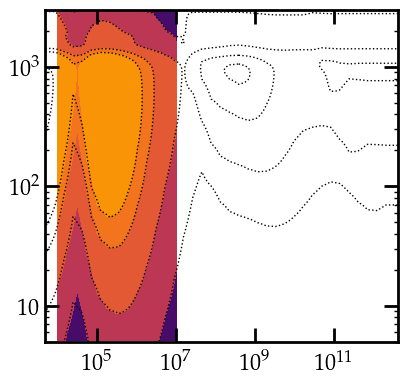

In [218]:
plt.figure(figsize=(10, 25))

# f_low_list = [f_low_H_ion_arr, f_low_He_ion_arr, f_low_exc_arr, f_low_heat_arr, f_low_cont_arr]
# f_high_list = 

plt.subplot(5, 2, 1)

ax = plt.gca()

ax.loglog()

# ax.contourf(
#     10**log10eng_arr[8:16] - phys.me, result_decay[0]['rs'], 
#     np.transpose(np.log10(0*f_high_heat_arr + f_low_heat_arr)), 
#     levels = np.log10([1e-7, 1e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 3e-1, 1]),
# #     norm=matplotlib.colors.LogNorm(),
#     cmap=matplotlib.cm.inferno
# )

ax.contourf(
    eng_phot, result_decay[0]['rs'], 
    np.transpose(np.log10(f_high_H_ion_arr + 0*f_low_H_ion_arr)), 
    levels = np.log10([1e-7, 1e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 3e-1, 1]),
#     norm=matplotlib.colors.LogNorm(),
    cmap=matplotlib.cm.inferno
)

ax.contour(
    10**log10eng_arr, idl_redshift, 
    np.transpose(np.log10(f_idl_high[:,0,:] + 0*f_idl_low[:,3,:])), 
    levels = np.log10([1e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 3e-1]), linestyles=':', linewidths=1, colors='k'
)

# ax.contour(
#     10**log10eng_arr - phys.me, idl_redshift, 
#     np.transpose(np.log10(f_H_ion_2016)), 
#     levels = np.log10([1e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 3e-1]), linestyles=':', linewidths=1, colors='k'
# )



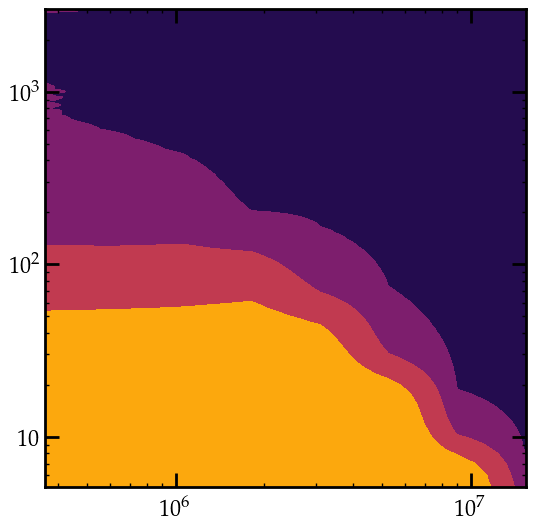

In [181]:
plt.figure()

ax = plt.gca()

ax.loglog()

ax.contourf(
    10**log10eng_arr[8:16] - phys.me, (result_decay[0]['rs']), 
    np.transpose((f_high_H_ion_arr + f_low_H_ion_arr)/f_H_ion_2016[8:16, 0:-20:12] - 1), 
    levels = [-0.5 -0.1, 0.1, 0.5, 1 , 2],
#     norm=matplotlib.colors.LogNorm(),
    cmap=matplotlib.cm.inferno
)

[5, 3000, 0.001, 0.5]

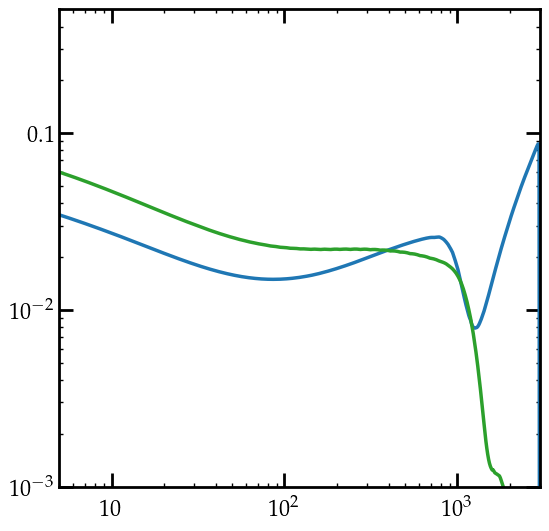

In [229]:
plt.figure()
plt.loglog()

i = 0

plt.plot(result_decay[i]['rs'], f_low_H_ion_arr[i] + 0.*f_high_H_ion_arr[i])
plt.plot(idl_redshift, f_idl_low[i+8,0,:] + 0.*f_idl_high[i+8,0,:])
plt.plot(result_decay[i]['rs'], 0*f_low_H_ion_arr[i] + f_high_H_ion_arr[i])
plt.plot(idl_redshift, 0*f_idl_low[i+8,0,:] + f_idl_high[i+8,0,:])

plt.axis([5, 3000, 1e-3, 0.5])

In [211]:
10**np.log10(10**log10eng_arr - phys.me)[8:16]

array([  362388.82714333,   619013.88315217,  1057367.55339747,
        1806140.65921187,  3085156.21684868,  5269904.55245798,
        9001778.85332003, 15376373.84462399])

In [233]:
log10eng_arr[8]

5.941207107839362